In [1]:
# Initialization

import pandas as pd
import os
import json

%matplotlib inline
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.line_width', 5000) 
pd.set_option('display.max_columns', 60)

DATA_PATH = "../data/yellow_sample_001.csv"
OUTPUT_PATH = "../heatmap-visualizer/maps"

# Dataset: 0.1% Sample

Load data:

In [2]:
data = pd.read_csv(DATA_PATH,
                   parse_dates=["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime"],
                   index_col="Trip_Pickup_DateTime")

Clean data:

In [3]:
data = data[(data["Start_Lon"] >= -80) & (data["Start_Lon"] <= -70)]
data = data[(data["Start_Lat"] >= 40) & (data["Start_Lat"] <= 50)]

Augment data with useful attributes:

In [4]:
data["Weekday"] = data.index.weekday
data["Year"] = data.index.year
data["Month"] = data.index.month
data["Hour"] = data.index.hour

Discretize Latitute & Longitudes:

In [5]:
ROUND_PARAM = 3
DISCRETIZED_COLUMN_NAMES = ["Start_Lon_discretized", "Start_Lat_discretized"]

data["Start_Lon_discretized"] = data["Start_Lon"].round(ROUND_PARAM)
data["Start_Lat_discretized"] = data["Start_Lat"].round(ROUND_PARAM)

## Helper Methods

In [6]:
def make_json(counts, title, normalize_value):
    points = []
    for i in range(len(counts)):
        lon, lat = counts.index[i]
        count = counts[i]
        points.append({"lat": lat, "lon": lon, "weight": float(count) / normalize_value})
    
    return {
        "title": title,
        "pointRadius": 10,
        "data": points
    }

## Average Pickup Count

In [7]:
counts = data[DISCRETIZED_COLUMN_NAMES].groupby(DISCRETIZED_COLUMN_NAMES).aggregate(len)

Count stats

In [8]:
len(counts)

16081

In [9]:
counts.max()

5464

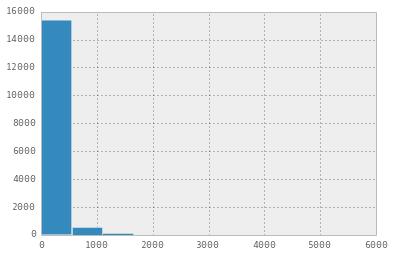

In [10]:
counts.hist()

Save Data to JSON

In [11]:
with open(os.path.join(OUTPUT_PATH, "average_pickup_count.json"), "w") as outfile:
    json.dump(make_json(counts, "Average Pickup Count", counts.max()), outfile)

## Average Pickup Count By Weekday

In [12]:
columns = ["Weekday"] + DISCRETIZED_COLUMN_NAMES
counts = data[columns].groupby(columns).aggregate(len)

In [13]:
counts.max()

864

In [14]:
output_dir = os.path.join(OUTPUT_PATH, "average_pickup_count_by_weekday")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for weekday in range(7):
    with open(os.path.join(output_dir, str(weekday) + ".json"), "w") as outfile:
        json.dump(make_json(counts[weekday], weekday_names[weekday], counts.max()), outfile)

## Average Pickup Count by Hour

In [15]:
columns = ["Hour"] + DISCRETIZED_COLUMN_NAMES
counts = data[columns].groupby(columns).aggregate(len)

In [16]:
output_dir = os.path.join(OUTPUT_PATH, "average_pickup_count_by_hour")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for hour in range(24):
    with open(os.path.join(output_dir, "%02d.json" % hour), "w") as outfile:
        json.dump(make_json(counts[hour], "%02d:00" % hour, counts.max()), outfile)

# Fridays

Here, we want to show four consecutive Fridays at the same hour in order to clarify if there are differences between very similar times (same weekday & hour).

In [38]:
BASE_DIR = "../data/Fridays"
ROUND_PARAM = 3
COLUMN_NAMES = ["Day", "pickup_longitude_discretized", "pickup_latitude_discretized"]

def read_friday_csv(filename):
    data = pd.read_csv(os.path.join(BASE_DIR, filename),
                       parse_dates=["pickup_datetime", "dropoff_datetime"],
                       index_col="pickup_datetime",
                       low_memory=False)
    
    data = data[(data["pickup_longitude"] >= -80) & (data["pickup_longitude"] <= -70)]
    data = data[(data["pickup_latitude"] >= 40) & (data["pickup_latitude"] <= 50)]
    data = data[(data.index.weekday == 4) & (data.index.hour == 19)]
    
    data["Day"] = data.index.dayofyear
    data["pickup_longitude_discretized"] = data["pickup_longitude"].round(ROUND_PARAM)
    data["pickup_latitude_discretized"] = data["pickup_latitude"].round(ROUND_PARAM)
    return data[COLUMN_NAMES]

In [53]:
FILENAMES = ["yellow_tripdata_2013-08-23_2013-08-23.csv",
             "yellow_tripdata_2013-08-30_2013-08-30.csv",
             "yellow_tripdata_2013-09-06_2013-09-06.csv",
             "yellow_tripdata_2013-09-13_2013-09-13.csv"]
LABELS = ["Friday, Aug 23 2013, 19:00 - 20:00",
          "Friday, Aug 30 2013, 19:00 - 20:00",
          "Friday, Sep 06 2013, 19:00 - 20:00",
          "Friday, Sep 13 2013, 19:00 - 20:00"]

In [ ]:
data = pd.concat([read_friday_csv(f) for f in FILENAMES])

In [ ]:
DAYS = data["Day"].unique()
data["Day"].value_counts()

In [49]:
counts = data.groupby(COLUMN_NAMES).aggregate(len)

In [52]:
output_dir = os.path.join(OUTPUT_PATH, "four_fridays")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for day, label, index in zip(DAYS, LABELS, range(len(DAYS))):
    with open(os.path.join(output_dir, "%02d.json" % index), "w") as outfile:
        json.dump(make_json(counts[day], label, counts.max()), outfile)